## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [35]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Sun Mar 31 00:24:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 419.35       Driver Version: 419.35       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0    N/A /  N/A |   1242MiB /  2048MiB |     40%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [24]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
import tensorflow as tf
from numba import cuda
import itertools
import matplotlib.pyplot as plt
plt.style.use('ggplot')

cuda.select_device(0)
cuda.close()
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [25]:
train, test = keras.datasets.cifar10.load_data()

In [26]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [27]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [28]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層

In [29]:
def build_mlp(input_shape, regularization, output_units=y_train.shape[-1], n_layers=4, num_neurons=[512, 256, 128, 64]):
    
    input_layer = keras.layers.Input(input_shape)
    
    if regularization == 'Regularizer':
        kr = keras.regularizers.l1(1e-4)
    else:
        kr = None
    
    for i, n_units in enumerate(num_neurons[:n_layers]):
        if regularization == 'BatchNormalization' and i == 0:
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units,
                                       activation='relu',
                                       name='hidden_layers'+str(i+1),
                                       kernel_regularizer=kr)(x)
        elif i == 0:
            x = keras.layers.Dense(units=n_units,
                                       activation='relu',
                                       name='hidden_layers'+str(i+1),
                                       kernel_regularizer=kr)(input_layer)
        else:
            if regularization == 'BatchNormalization':
                x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units,
                                       activation='relu',
                                       name='hidden_layers'+str(i+1),
                                       kernel_regularizer=kr)(x)
            
        if regularization == 'Dropout':
            x = keras.layers.Dropout(0.1)(x)
        
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [30]:
## 超參數設定
LEARNING_RATE = 1e-3
OPTIMIZER = 'adam'
EPOCHS = 50
BATCH_SIZE = 512

REGULARIZATION = ['Regularizer', 'BatchNormalization', 'Dropout']

In [31]:
def model_fitting(regularization, learning_rate=LEARNING_RATE, optimizer=OPTIMIZER, epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:]):
    
    keras.backend.clear_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    
    model = build_mlp(input_shape=input_shape, regularization=regularization)
    model.summary()
    
    switcher = {'sgd': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'rmsp': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'adag': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}
    optimizer = switcher.get(optimizer)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_test, y_test), 
                        shuffle=False,
                        verbose=1)
    
    sess.close()

    return history

In [32]:
results = {}

for regularization in REGULARIZATION:
    
    history = model_fitting(regularization=regularization)
    
    name_tag = f'{regularization}'
    results[name_tag] = {'train_loss': history.history['loss'],
                         'valid_loss': history.history['val_loss'],
                         'train_acc': history.history['acc'],
                         'valid_acc': history.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128)               32896     
_________________________________________________________________
hidden_layers4 (Dense)       (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 1,746,506
Trainable params: 1,746,506
Non-trainable params: 0
_________________________________________________________________


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.7093 - acc: 0.3964 - val_loss: 1.5203 - val_acc: 0.4627
Epoch 2/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.4201 - acc: 0.4944 - val_loss: 1.4345 - val_acc: 0.4966c: 0.493
Epoch 3/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.2775 - acc: 0.5473 - val_loss: 1.4003 - val_acc: 0.5054
Epoch 4/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.1618 - acc: 0.5901 - val_loss: 1.3828 - val_acc: 0.5172
Epoch 5/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.0634 - acc: 0.6266 - val_loss: 1.4064 - val_acc: 0.5126
Epoch 6/50
50000/50000 [==============================] - 5s 104us/step - loss: 0.9692 - acc: 0.6604 - val_loss: 1.4265 - val_acc: 0.5164
Epoch 7/50
50000/50000 [==============================] - 5s 105us/step - loss: 0.8854 - acc: 0.6914 - val_loss: 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 123us/step - loss: 2.0691 - acc: 0.2263 - val_loss: 1.8613 - val_acc: 0.3338
Epoch 2/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.8360 - acc: 0.3357 - val_loss: 1.7340 - val_acc: 0.3722
Epoch 3/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.7541 - acc: 0.3680 - val_loss: 1.6560 - val_acc: 0.4027
Epoch 4/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.6944 - acc: 0.3946 - val_loss: 1.6250 - val_acc: 0.4220
Epoch 5/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.6455 - acc: 0.4114 - val_loss: 1.5851 - val_acc: 0.4323
Epoch 6/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.6081 - acc: 0.4242 - val_loss: 1.5336 - val_acc: 0.4567
Epoch 7/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.5712 - acc: 0.4366 - val_loss: 1.5131 - val_a

In [33]:
colors = ['#9a0eea', '#15b01a', '#0343df', '#ff81c0', '#653700', 
          '#e50000', '#95d0fc', '#f97306', '#c20078', '#ffff14',
          '#06c2ac', '#00035b', '#d1b26f', '#677a04', '#ae7181', '#ffb07c']

def plotting(results, color_bar=colors):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    
    for i, cond in enumerate(results.keys()):

        epochs = range(1, len(results[cond]['train_loss']) + 1)

        ax1.plot(epochs, results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
        ax1.plot(epochs, results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
        
        ax2.plot(epochs, results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
        ax2.plot(epochs, results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
        
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_title('Loss', fontsize=25)
    ax1.legend()
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_title('Accuracy', fontsize=25)
    ax2.legend()
    plt.show()

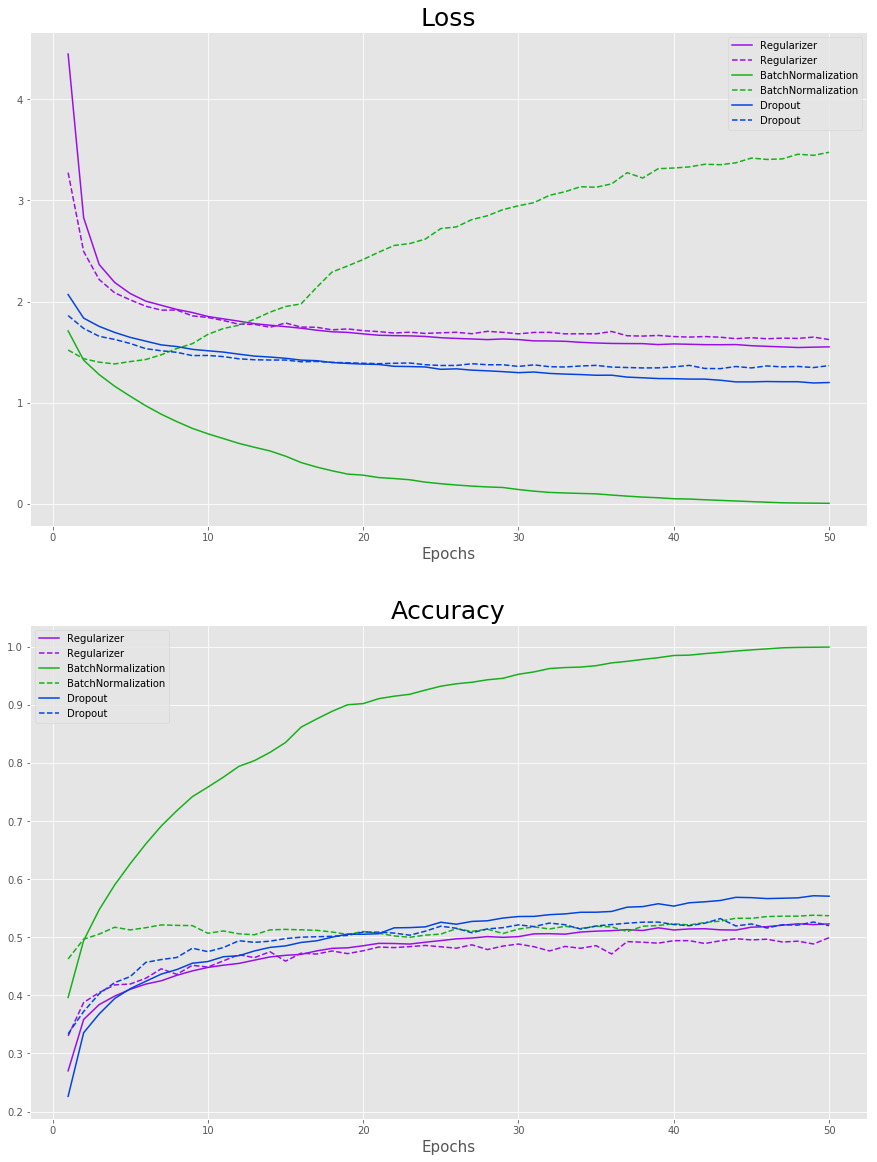

In [34]:
plotting(results)

In [ ]:
cuda.select_device(0)
cuda.close()